# Imports

In [537]:
import pandas as pd
import numpy as np
import json
import datetime
import ast
import seaborn as sns

from sklearn import preprocessing as pp
import pickle

from sklearn import model_selection as ms
import category_encoders as ce

#from boruta   import BorutaPy
from lightgbm import LGBMClassifier

from sklearn.ensemble        import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost                 import XGBRegressor
from sklearn.linear_model    import LogisticRegression, SGDRegressor
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor, BaggingRegressor
from sklearn.metrics         import accuracy_score, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes     import GaussianNB
from lightgbm                import LGBMRegressor

## Helper Functions

In [538]:
def test_preparation(X_test, y_test):
    X_test = rescalling(X_test)
    X_test = transform(X_test)
    y_test = log_var_resposta(y_test)
    
    return X_test, y_test


def rescalling (X_test):
    
    mm = pickle.load(open('parameters/mm_avg_delivery_time_days.pkl','rb'))
    X_test['avg_delivery_time_days'] = mm.transform(X_test[['avg_delivery_time_days']])
    
    rs_ar = pickle.load(open('parameters/rs_average_rating.pkl','rb'))
    
    X_test['average_rating'] = rs_ar.transform(X_test[['average_rating']])
    
    rs_nr = pickle.load(open('parameters/rs_number_of_reviews.pkl','rb'))
    
    X_test['number_of_reviews'] = rs_nr.transform(X_test[['number_of_reviews']])
    
    return X_test

def transform (df):
    
    for att in ['Ideal For', 'Reversible', 'Suitable For', 'seller', 'product', 'Type', 'Sleeve', 'Fit']:
        te = pickle.load(open(f'parameters/te_{att}.pkl','rb'))
        df = te.transform(df)        
    
    for att in ['brand','Style Code','Pack of', 'Pattern']:
        fe = pickle.load(open(f'parameters/fe_{att}.pkl', 'rb'))
        df = fe.transform(df)
    
    return df

def log_var_resposta(df):
    df = np.log1p(df)
    return df

def limpeza (df):
    df = df.drop(columns=['_id', 'pid','description', 'images'])
    # transformando de string para data
    df['crawled_at'] = pd.to_datetime(df['crawled_at']).dt.date

    return df

def feature_engen(df):
    ## out_of_stock - transformar para int 
    df['out_of_stock'] = df['out_of_stock'].astype('int64')

    # brand - substituir por outros
    df['brand'] = df['brand'].apply(lambda x: x.lower())

    # criando feature product
    df['product'] = df[['category', 'sub_category']].apply(lambda x: x['category'] + '_' + x['sub_category'], axis = 1)
    
    df.loc[df['number_of_reviews'] == 0, 'average_rating'] = -1
    
    import ast

    # pega string de dict e cria uma lista de dicionários
    def f(x):
        try:
            return ast.literal_eval(str(x))   
        except Exception as e:
            print(e)
            return []



    def junta_dict(dict_list):
        dicionario = {}
        for d in dict_list:
            for key, value in d.items():
                dicionario[key] = value
        return dicionario

    list = df['product_details'].apply(lambda x: f(x))

    df_details = pd.DataFrame([junta_dict(row) for row in list], index = list.index)

    df_drop_columns = df_details.drop(columns=['', ' '])

    # Removendo valores faltantes acima de 50%
    limite_nulos = len(df_details) * 0.5  
    df_drop = df_details.dropna(thresh = limite_nulos, axis=1)
    df_new = df_drop.copy()

    # Trocar os NaN por 'outros'

    df_new.loc[df_new['Fabric'].isnull(), 'Fabric'] = 'outros'
    df_new.loc[df_new['Pattern'].isnull(), 'Pattern'] = 'outros'
    df_new.loc[df_new['Style Code'].isnull(), 'Style Code'] = 'outros'
    df_new.loc[df_new['Pack of'].isnull(), 'Pack of'] = 'outros'
    df_new.loc[df_new['Type'].isnull(), 'Type'] = 'outros'
    df_new.loc[df_new['Sleeve'].isnull(), 'Sleeve'] = 'outros'
    df_new.loc[df_new['Fit'].isnull(), 'Fit'] = 'outros'
    df_new.loc[df_new['Ideal For'].isnull(), 'Ideal For'] = 'outros'
    df_new.loc[df_new['Suitable For'].isnull(), 'Suitable For'] = 'outros'
    df_new.loc[df_new['Reversible'].isnull(), 'Reversible'] = 'outros'
    df_new.loc[df_new['Fabric Care'].isnull(), 'Fabric Care'] = 'outros'

    df_new.head()

    def type_sex(value):
        if value == 'Men':
            return 'Men'
        elif value == 'Men, Boys':
            return 'all_ages'
        elif value == 'Boys, Men':
            return 'all_ages'
        elif value == 'Boys, Girls, Men, Women':
            return 'unisex_all_ages'
        elif value == 'Women, Men':
            return 'Unisex'
        else:
            return 'outros'

    df_new['Ideal For'] = df_new['Ideal For'].map(type_sex)

    df = pd.concat([df, df_new], axis=1)
    
    df['cotton'] = df['Fabric'].apply(lambda x: 1 if 'cotton' in x.lower() else 0)
    df['poly'] = df['Fabric'].apply(lambda x: 1 if 'poly' in x.lower() else 0)
    df['not_cotton_or_poly'] = df['Fabric'].apply(lambda x: 1 if ('poly' not in x.lower()) and ('cotton' not in x.lower()) else 0)
    
    return df

# Load Data

In [539]:
# Opening JSON file
train = open('dataset/raw/train.json')
 
# returns JSON object as 
# a dictionary
data_train_aux = json.load(train)

data_train = pd.json_normalize(data_train_aux, record_path = 'data')
data_train.columns = data_train_aux['columns']
data_train.head()

,_id,average_rating,number_of_reviews,brand,category,crawled_at,description,images,out_of_stock,avg_delivery_time_days,pid,product_details,seller,sub_category,fabrication_time,title,actual_price
0,53df9662-e500-569c-946e-0c8d215a72cd,3.2,26,East I,Clothing and Accessories,2021-02-10 21:17:28,Navy Blue Printed Boxers Has An Inner Elasti...,['https://rukminim1.flixcart.com/image/128/128...,False,8,BXRFTZF7JGX75DAW,"[{'Color': 'Dark Blue'}, {'Fabric': 'Pure Cott...",ZIYAA,Innerwear and Swimwear,653,Printed Men Boxer (Pack of 1),849.0
1,d0142842-84f7-537d-a06f-d85b76488a5f,4.0,33,dream o,Clothing and Accessories,2021-02-11 01:02:46,smiley printed tshirt on round neck cotton tshirt,['https://rukminim1.flixcart.com/image/128/128...,False,12,TSHFWQM96UHR6A4Q,"[{'Type': 'Round Neck'}, {'Sleeve': 'Short Sle...",Dream Onn Creations,Topwear,668,Printed Men Round Neck Orange T-Shirt,699.0
2,79c8f0d7-30b1-5dd4-9f2f-2fe97782b027,3.9,32,Free Authori,Clothing and Accessories,2021-02-11 00:43:37,Free Authority Presents this Crew Neck Yellow ...,['https://rukminim1.flixcart.com/image/128/128...,False,11,SWSFWCXH2WF6ZYRB,"[{'Color': 'Yellow'}, {'Fabric': 'Polycotton'}...",BioworldMerchandising,Winter Wear,53,Full Sleeve Graphic Print Men Sweatshirt,1499.0
3,0531c28c-7c50-5fbd-9ce3-a7cae3243ad5,3.8,31,HUMBE,Clothing and Accessories,2021-02-10 21:22:10,Cotton Blend FabricCollar / Polo Neck White & ...,['https://rukminim1.flixcart.com/image/128/128...,False,11,TSHFHQH3HKDAGGK9,"[{'Type': 'Polo Neck'}, {'Sleeve': 'Short Slee...",HUMBERT,Topwear,510,"Solid Men Polo Neck Light Blue, White T-Shirt ...",1699.0
4,d604baad-472e-5c18-86a3-7b46d4a890c2,2.4,20,Rose We,Clothing and Accessories,2021-02-10 23:36:36,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,5,TSHFW9CJZSYUU6UX,"[{'Type': 'Round Neck'}, {'Sleeve': 'Short Sle...",Rupalcollectionjaipur,Topwear,496,Printed Men Round Neck White T-Shirt,599.0


# Data Description

In [540]:
# retirar descrição
# retirar imagem
# verificar ids duplicados em id produto
# Verificar outliers no price

## Removendo colunas

In [541]:
data_train = data_train.drop(columns=['description', 'images'])

## Transformando tipo de dados

In [542]:
data_train.dtypes

_id                        object
average_rating            float64
number_of_reviews           int64
brand                      object
category                   object
crawled_at                 object
out_of_stock                 bool
avg_delivery_time_days      int64
pid                        object
product_details            object
seller                     object
sub_category               object
fabrication_time            int64
title                      object
actual_price              float64
dtype: object

In [543]:
# transformando de string para data
data_train['crawled_at'] = pd.to_datetime(data_train['crawled_at']).dt.date

## Tratando valores nulos

In [544]:
data_train.isna().sum()/data_train.shape[0]

_id                       0.000000
average_rating            0.000000
number_of_reviews         0.000000
brand                     0.000000
category                  0.000000
crawled_at                0.000000
out_of_stock              0.000000
avg_delivery_time_days    0.000000
pid                       0.000000
product_details           0.000000
seller                    0.000000
sub_category              0.000000
fabrication_time          0.000000
title                     0.000000
actual_price              0.149985
dtype: float64

In [545]:
data_train = data_train.dropna(subset=['actual_price'])

In [546]:
data_train.isna().sum()/data_train.shape[0]

_id                       0.0
average_rating            0.0
number_of_reviews         0.0
brand                     0.0
category                  0.0
crawled_at                0.0
out_of_stock              0.0
avg_delivery_time_days    0.0
pid                       0.0
product_details           0.0
seller                    0.0
sub_category              0.0
fabrication_time          0.0
title                     0.0
actual_price              0.0
dtype: float64

## Entendendo product Details

In [547]:
import ast

# pega string de dict e cria uma lista de dicionários
def f(x):
    try:
        return ast.literal_eval(str(x))   
    except Exception as e:
        print(e)
        return []

teste = data_train['product_details'].apply(lambda x: f(x))

def junta_dict(dict_list):
    dicionario = {}
    for d in dict_list:
        for key, value in d.items():
            dicionario[key] = value
    return dicionario


df = pd.DataFrame([junta_dict(row) for row in teste])

In [548]:
df = pd.DataFrame([junta_dict(row) for row in teste])
df.isna().sum().sort_values()

Fabric               1491
Style Code           1653
Pattern              1661
Fabric Care          4305
Suitable For         6120
                    ...  
Shoulder in inch    19811
Pleated             19812
Region              19812
Design              19812
Fabric care         19812
Length: 124, dtype: int64

# Feature Engineering

In [549]:
df4 = data_train.copy()

In [550]:
## out_of_stock - transformar para int 
df4['out_of_stock'] = df4['out_of_stock'].astype('int64')

# brand - substituir por outros
df4['brand'] = df4['brand'].apply(lambda x: x.lower())

# criando feature product
df4['product'] = df4[['category', 'sub_category']].apply(lambda x: x['category'] + '_' + x['sub_category'], axis = 1)

df4.loc[df4['number_of_reviews'] == 0, 'average_rating'] = -1

In [551]:
import ast

# pega string de dict e cria uma lista de dicionários
def f(x):
    try:
        return ast.literal_eval(str(x))   
    except Exception as e:
        print(e)
        return []



def junta_dict(dict_list):
    dicionario = {}
    for d in dict_list:
        for key, value in d.items():
            dicionario[key] = value
    return dicionario

list = df4['product_details'].apply(lambda x: f(x))

df_details = pd.DataFrame([junta_dict(row) for row in list], index = list.index)

df_drop_columns = df_details.drop(columns=['', ' '])

# Removendo valores faltantes acima de 50%
limite_nulos = len(df_details) * 0.5  
df_drop = df_details.dropna(thresh = limite_nulos, axis=1)
df_new = df_drop.copy()

# Trocar os NaN por 'outros'

df_new.loc[df_new['Fabric'].isnull(), 'Fabric'] = 'outros'
df_new.loc[df_new['Pattern'].isnull(), 'Pattern'] = 'outros'
df_new.loc[df_new['Style Code'].isnull(), 'Style Code'] = 'outros'
df_new.loc[df_new['Pack of'].isnull(), 'Pack of'] = 'outros'
df_new.loc[df_new['Type'].isnull(), 'Type'] = 'outros'
df_new.loc[df_new['Sleeve'].isnull(), 'Sleeve'] = 'outros'
df_new.loc[df_new['Fit'].isnull(), 'Fit'] = 'outros'
df_new.loc[df_new['Ideal For'].isnull(), 'Ideal For'] = 'outros'
df_new.loc[df_new['Suitable For'].isnull(), 'Suitable For'] = 'outros'
df_new.loc[df_new['Reversible'].isnull(), 'Reversible'] = 'outros'
df_new.loc[df_new['Fabric Care'].isnull(), 'Fabric Care'] = 'outros'

df_new.head()

def type_sex(value):
    if value == 'Men':
        return 'Men'
    elif value == 'Men, Boys':
        return 'all_ages'
    elif value == 'Boys, Men':
        return 'all_ages'
    elif value == 'Boys, Girls, Men, Women':
        return 'unisex_all_ages'
    elif value == 'Women, Men':
        return 'Unisex'
    else:
        return 'outros'

df_new['Ideal For'] = df_new['Ideal For'].map(type_sex)

df4 = pd.concat([df4, df_new], axis=1)

## Tratando variaveis respostas nulas
prices = df4[['seller','pid', 'actual_price']].groupby('pid').max().reset_index()

precos_nulos = df4.loc[df4['actual_price'].isna(), ['_id','pid']]

precos_recuperados = pd.merge(precos_nulos, prices, how = 'inner', on = 'pid')

df4_aux = pd.merge(df4, precos_recuperados[['_id', 'actual_price']], on = '_id', how = 'left')
df4['actual_price'] = df4_aux['actual_price_x'].fillna(0) + df4_aux['actual_price_y'].fillna(0)

df4 = df4.dropna(subset=['actual_price'])

df4 = df4.loc[df4['actual_price'] <= 8000]

# Novas Features de roupa

df4['cotton'] = df4['Fabric'].apply(lambda x: 1 if 'cotton' in x.lower() else 0)
df4['poly'] = df4['Fabric'].apply(lambda x: 1 if 'poly' in x.lower() else 0)
df4['not_cotton_or_poly'] = df4['Fabric'].apply(lambda x: 1 if ('poly' not in x.lower()) and ('cotton' not in x.lower()) else 0)

# EDA

In [552]:
df5 = df4.copy()

In [553]:
df5.loc[df5['actual_price'] > 8000]

,_id,average_rating,number_of_reviews,brand,category,crawled_at,out_of_stock,avg_delivery_time_days,pid,product_details,...,Type,Sleeve,Fit,Ideal For,Suitable For,Reversible,Fabric Care,cotton,poly,not_cotton_or_poly


<AxesSubplot:xlabel='actual_price', ylabel='Count'>

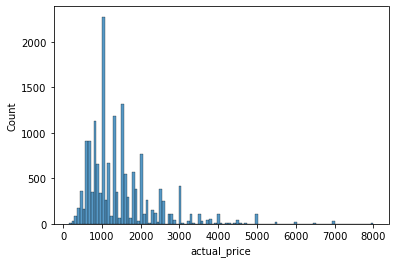

In [554]:
sns.histplot(df5['actual_price'])

# Data Preparation

In [555]:
df6 = df5.copy()

In [556]:
df6.isna().sum()

_id                       0
average_rating            0
number_of_reviews         0
brand                     0
category                  0
crawled_at                0
out_of_stock              0
avg_delivery_time_days    0
pid                       0
product_details           0
seller                    0
sub_category              0
fabrication_time          0
title                     0
actual_price              0
product                   0
Fabric                    0
Pattern                   0
Style Code                0
Pack of                   0
Type                      0
Sleeve                    0
Fit                       0
Ideal For                 0
Suitable For              0
Reversible                0
Fabric Care               0
cotton                    0
poly                      0
not_cotton_or_poly        0
dtype: int64

## Split Dataset

In [557]:
X = df6.drop(['_id','pid','actual_price'], axis=1)
y = df6['actual_price']

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=1)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

## Rescalling

In [558]:
X_train.columns

Index(['average_rating', 'number_of_reviews', 'brand', 'category',
       'crawled_at', 'out_of_stock', 'avg_delivery_time_days',
       'product_details', 'seller', 'sub_category', 'fabrication_time',
       'title', 'product', 'Fabric', 'Pattern', 'Style Code', 'Pack of',
       'Type', 'Sleeve', 'Fit', 'Ideal For', 'Suitable For', 'Reversible',
       'Fabric Care', 'cotton', 'poly', 'not_cotton_or_poly'],
      dtype='object')

### Min Max Scaler

In [559]:
mm = pp.MinMaxScaler()

X_train['avg_delivery_time_days'] = mm.fit_transform(X_train[['avg_delivery_time_days']])
pickle.dump(mm, open('parameters/mm_avg_delivery_time_days.pkl','wb'))

2023-10-22 14:39:14,176 [33076] WARNING  py.warnings:109: [JupyterRequire] C:\Users\Notebook\AppData\Local\Temp/ipykernel_33076/2287114027.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['avg_delivery_time_days'] = mm.fit_transform(X_train[['avg_delivery_time_days']])



### Robust Scaler

In [560]:
rs_average_rating   = pp.RobustScaler()
rs_number_of_reviews = pp.RobustScaler()

X_train['average_rating'] = rs_average_rating.fit_transform(X_train[['average_rating']])
pickle.dump(rs_average_rating, open('parameters/rs_average_rating.pkl','wb'))

X_train['number_of_reviews'] = rs_number_of_reviews.fit_transform(X_train[['number_of_reviews']])
pickle.dump(rs_number_of_reviews, open('parameters/rs_number_of_reviews.pkl','wb'))

2023-10-22 14:39:14,232 [33076] WARNING  py.warnings:109: [JupyterRequire] C:\Users\Notebook\AppData\Local\Temp/ipykernel_33076/3765211346.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['average_rating'] = rs_average_rating.fit_transform(X_train[['average_rating']])

2023-10-22 14:39:14,257 [33076] WARNING  py.warnings:109: [JupyterRequire] C:\Users\Notebook\AppData\Local\Temp/ipykernel_33076/3765211346.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['number_of_reviews'] = rs_number

## Transformation

### One Hot Enconde

In [561]:
# 'out_of_stock'

### Target Encode

In [562]:
for att in ['Ideal For', 'Reversible', 'Suitable For', 'seller', 'product', 'Type', 'Fit', 'Sleeve']:
    te = ce.TargetEncoder(cols=[att]).fit(X_train, y_train)
    pickle.dump(te, open(f'parameters/te_{att}.pkl','wb'))
    X_train = te.transform(X_train)

### Frequency Encode

In [563]:
for att in ['brand','Style Code','Pack of', 'Pattern']:
    fe =  ce.CountEncoder(cols=[att], normalize=True).fit(X_train)
    pickle.dump(fe,open(f'parameters/fe_{att}.pkl', 'wb'))
    X_train = fe.transform(X_train)

### Response Variable

In [564]:
y_train = np.log1p(y_train)

## Test Preparation

In [565]:
X_test_mod, y_test_mod = test_preparation(X_test, y_test)

2023-10-22 14:39:17,974 [33076] WARNING  py.warnings:109: [JupyterRequire] C:\Users\Notebook\AppData\Local\Temp/ipykernel_33076/3459282624.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['avg_delivery_time_days'] = mm.transform(X_test[['avg_delivery_time_days']])

2023-10-22 14:39:18,031 [33076] WARNING  py.warnings:109: [JupyterRequire] C:\Users\Notebook\AppData\Local\Temp/ipykernel_33076/3459282624.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['average_rating'] = rs_ar.transform(

In [566]:
X_test_mod.isna().sum()

average_rating            0
number_of_reviews         0
brand                     0
category                  0
crawled_at                0
out_of_stock              0
avg_delivery_time_days    0
product_details           0
seller                    0
sub_category              0
fabrication_time          0
title                     0
product                   0
Fabric                    0
Pattern                   0
Style Code                0
Pack of                   0
Type                      0
Sleeve                    0
Fit                       0
Ideal For                 0
Suitable For              0
Reversible                0
Fabric Care               0
cotton                    0
poly                      0
not_cotton_or_poly        0
dtype: int64

# Feature Selection

In [567]:
X_train.columns.tolist()

['average_rating',
 'number_of_reviews',
 'brand',
 'category',
 'crawled_at',
 'out_of_stock',
 'avg_delivery_time_days',
 'product_details',
 'seller',
 'sub_category',
 'fabrication_time',
 'title',
 'product',
 'Fabric',
 'Pattern',
 'Style Code',
 'Pack of',
 'Type',
 'Sleeve',
 'Fit',
 'Ideal For',
 'Suitable For',
 'Reversible',
 'Fabric Care',
 'cotton',
 'poly',
 'not_cotton_or_poly']

In [568]:
# 'Style Code','Pack of','Ideal For','Suitable For','Reversible',

In [569]:
# 'brand','Style Code','Pack of', 'Pattern'
# 'Ideal For', 'Reversible', 'Suitable For', 'seller', 'product', 'Type', 'Fit', 'Sleeve'

In [570]:
features_selected = [
'average_rating',
'number_of_reviews',
'brand',
# 'category',
# 'crawled_at',
'out_of_stock',
'avg_delivery_time_days',
#  'product_details',
'seller',
#  'sub_category',
#  'fabrication_time',
#  'title',
#  'Fabric',
 'Pattern',
'cotton',
'poly',
'not_cotton_or_poly',
'Style Code',
'Pack of',
'Type',
 'Sleeve',
 'Fit',
'Ideal For',
'Suitable For',
'Reversible',
#  'Fabric Care',
'product'
]

## Importancia das árvores

In [571]:
# Crie e treine o modelo LGBMClassifier
lgb_model = LGBMRegressor(n_jobs=-1, random_state=42)
X_train_sel = X_train[features_selected]
lgb_model.fit(X_train_sel, y_train)

# Obtenha as importâncias das características do modelo
importances = lgb_model.feature_importances_

# Ordene as características por importância decrescente
indices = np.argsort(importances)[::-1]

# Imprima o ranking das características
print('Feature ranking')
df = pd.DataFrame()

for i, j in zip(X_train_sel.columns, importances):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

Feature ranking
                  feature  importance
0                  seller         526
0          average_rating         500
0                   brand         373
0                 Pattern         373
0                    Type         289
0                  Sleeve         168
0                     Fit         165
0              Style Code         144
0                 Pack of         120
0                 product         118
0                  cotton          48
0              Reversible          46
0                    poly          38
0            Suitable For          31
0               Ideal For          25
0            out_of_stock          13
0      not_cotton_or_poly          12
0  avg_delivery_time_days          11
0       number_of_reviews           0


# Machine Learning

In [572]:
def MachineLearning(X_train, y_train, X_test, y_test, features_selected):
    SEED = 42

    lista_de_medidas = ['SMAPE']
    nome_das_medidas = ['SMAPE']

    lista_de_modelos = [XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=3),
                        LGBMRegressor(random_state=SEED, n_jobs=-1, force_row_wise=True, ),
                        DecisionTreeRegressor(random_state=SEED),
                        KNeighborsRegressor(n_neighbors=5,  weights='distance',n_jobs=-1),
                        BaggingRegressor(),
                        RandomForestRegressor(random_state=SEED)]

    nome_dos_modelos = ['XGBoost', 
                        'LGBM', 
                        'DecisionTree',
                        'KNN',
                        'Bagging',
                        'RandomForest']

    resultados0 = {}
    
    X_train_selected = X_train[features_selected]
    X_test_selected = X_test[features_selected]


    for i in range(len(lista_de_modelos)):
        print('Rodando modelo: ' + nome_dos_modelos[i])
        
        model = lista_de_modelos[i]
        
        model.fit(X_train_selected, y_train)
        
        y_pred = model.predict(X_test_selected)
        
        smape = 100 / len(y_test) * np.sum(2 * np.abs(np.expm1(y_pred) - np.expm1(y_test)) / (np.abs(np.expm1(y_test)) + np.abs(np.expm1(y_pred))))

        resultados0[nome_dos_modelos[i]] = [smape]
    
    resultados = pd.DataFrame(resultados0, index = nome_das_medidas).T

    return resultados

In [574]:
MachineLearning(X_train, y_train, X_test_mod, y_test_mod, features_selected)

Rodando modelo: XGBoost
Rodando modelo: LGBM
Rodando modelo: DecisionTree
Rodando modelo: KNN
Rodando modelo: Bagging
Rodando modelo: RandomForest


,SMAPE
XGBoost,41.576739
LGBM,42.025091
DecisionTree,48.574407
KNN,46.727894
Bagging,45.110386
RandomForest,44.531526


# Fine Tuning

- Não possui cross validation
- Não realiza reencode das variáveis
- **Para maior assertividade, rodar com todos os dados de treino disponíveis**

In [575]:
def objective_cv(trial):  
    
    n_estimators = trial.suggest_int('n_estimators',20, 100)
    eta = trial.suggest_float('eta',0.01, 0.05)
    max_depth = trial.suggest_int('max_depth', 3, 9)
    subsample = trial.suggest_float('subsample',0.1, 0.9)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.1,0.9)

    # model definition
    xgb_model = XGBRegressor( n_estimators    = n_estimators, 
                              eta              = eta, 
                              max_depth        = max_depth, 
                              subsample        = subsample,
                              colsample_bytree = colsample_bytree
                             )
    
    xgb_model.fit(X_train[features_selected], y_train)
    
    # Model Prediction 
    y_pred = xgb_model.predict(X_test_mod[features_selected])

    # calculando rmse
    smape = 100 / len(y_test_mod) * np.sum(2 * np.abs(np.expm1(y_pred) - np.expm1(y_test_mod)) / (np.abs(np.expm1(y_test_mod)) + np.abs(np.expm1(y_pred))))

    return smape

In [ ]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective_cv, n_trials=50)

[I 2023-10-22 14:40:43,393] A new study created in memory with name: no-name-013e7d51-a9e4-4862-9944-d108758592b0
[I 2023-10-22 14:40:43,749] Trial 0 finished with value: 128.17398226280187 and parameters: {'n_estimators': 45, 'eta': 0.03109879660113756, 'max_depth': 9, 'subsample': 0.22353126382613242, 'colsample_bytree': 0.6898734316634871}. Best is trial 0 with value: 128.17398226280187.
[I 2023-10-22 14:40:44,844] Trial 1 finished with value: 57.7702967373331 and parameters: {'n_estimators': 94, 'eta': 0.026308921551625244, 'max_depth': 8, 'subsample': 0.18836568151334054, 'colsample_bytree': 0.6984865484561382}. Best is trial 1 with value: 57.7702967373331.
[I 2023-10-22 14:40:45,702] Trial 2 finished with value: 149.90959976985366 and parameters: {'n_estimators': 80, 'eta': 0.014642352215979116, 'max_depth': 5, 'subsample': 0.8303691434020083, 'colsample_bytree': 0.2054818601143901}. Best is trial 1 with value: 57.7702967373331.
[I 2023-10-22 14:40:46,002] Trial 3 finished with v

In [529]:
# best_params = study.best_params
best_params = {'n_estimators': 100,
 'eta': 0.04847968659990019,
 'max_depth': 7,
 'subsample': 0.31355832178198495,
 'colsample_bytree': 0.5456941887941139}

In [530]:
best_model = XGBRegressor(n_jobs = -1 , 
                                 random_state=0,
                                 n_estimators = best_params['n_estimators'],
                                 eta = best_params['eta'],
                                 max_depth = best_params['max_depth'],
                                 subsample = best_params['subsample'],
                                 colsample_bytree = best_params['colsample_bytree'])

# model fit
best_model.fit(X_train[features_selected], y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5456941887941139, early_stopping_rounds=None,
             enable_categorical=False, eta=0.04847968659990019,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, ...)

## Submission

### Carregar os dados

In [531]:
# Opening JSON file
sub = open('dataset/raw/test.json')
 
# returns JSON object as 
# a dictionary
data_sub_aux = json.load(sub)

data_sub = pd.json_normalize(data_sub_aux, record_path = 'data')
data_sub.columns = data_sub_aux['columns']
data_sub.shape

(5600, 16)

### Transformar os dados

In [532]:
def submission_preparation(df, features_selected):
    
    df = limpeza(df)
    df = feature_engen(df)
    df = rescalling(df)
    df = transform(df)
    
    return df[features_selected]

### Aplicar sobre os dados de teste

In [533]:
data_sub_mod = submission_preparation(data_sub, features_selected)

In [534]:
y_hat = np.expm1(best_model.predict(data_sub_mod))

In [535]:
df_submission = pd.DataFrame()
df_submission['pid'] = data_sub['pid']
df_submission['actual_price'] = y_hat

In [536]:
df_submission.to_csv('submissions/submission_7.csv', index=False)

------
# 10 Help Functions

In [327]:
def f(x):
    try:
        return ast.literal_eval(str(x))   
    except Exception as e:
        print(e)
        return []

In [328]:
def junta_dict(dict_list):
    dicionario = {}
    for d in dict_list:
        for key, value in d.items():
            dicionario[key] = value
    return dicionario

In [329]:
def feature_engen(df):
    ## out_of_stock - transformar para int 
    df['out_of_stock'] = df['out_of_stock'].astype('int64')

    # brand - substituir por outros
    df['brand'] = df['brand'].apply(lambda x: x.lower())

    # criando feature product
    df['product'] = df[['category', 'sub_category']].apply(lambda x: x['category'] + '_' + x['sub_category'], axis = 1)
    
    ## Tratando variaveis respostas nulas
    prices = df[['seller','pid', 'actual_price']].groupby('pid').max().reset_index()
    precos_nulos = df.loc[df['actual_price'].isna(), ['_id','pid']]
    precos_recuperados = pd.merge(precos_nulos, prices, how = 'inner', on = 'pid')
    
    df_aux = pd.merge(df, precos_recuperados[['_id', 'actual_price']], on = '_id', how = 'left')
    df['actual_price'] = df_aux['actual_price_x'].fillna(0) + df_aux['actual_price_y'].fillna(0)
    
    df = df.dropna(subset=['actual_price'])
    
    return df

In [330]:
def pipeline (df):
    df = limpeza(df)
    df = feature_engen(df)
    
    product_details = df['product_details'].apply(lambda x: f(x))
    product_details = pd.DataFrame([junta_dict(row) for row in product_details])
    
    return df, product_details


In [331]:
def test_preparation(df):
    X_test = rescalling(X_test)
    X_test = transform(X_test)
    y_test = log_var_resposta(y_test)
    
    return X_test

In [332]:
# '_id'
# 'average_rating':         muitos outliers mas distribuição proxima da normal
#                           tratar notas que não possuem avaliação
# 'number_of_reviews':      muitos outliers mas distribuição proxima da normal
#                           ver como fica a distribuição como log
# 'brand':                  12 categorias frequency -> transformar tudo em minusculo para evitar duplicações
# 'category':               Uma categoria é mais majoritária 
#                           unir com a subcategory fazendo o tratamento de maiusculas
# 'crawled_at':             Somente 1 dia, muda somente a hora -> retirar XXXXX
# 'out_of_stock':           Dummie enconde (somente 0 ou 1) -> One hot encode
# 'avg_delivery_time_days': sem outliers e distribuição normal -> min max scaler
# 'pid':                    valore duplicatidos, muitas labels -> usar para preencher valores nulos no price mas não vai para o modelo
# 'seller':                 Reunir undefined em "outros" e usar o frequency encode
# 'sub_category':           Unir com o 'category'
# 'fabrication_time':       sem outliers, distribuição uniforme -> min max scaler
# 'title':                  muitas categorias, sem concentrações -> frequency 
#                           explorar mais o title
#                           deletar nesse momento
# 'actual_price':           transformar em escala log